## **RADI605: Modern Machine Learning**

### Assignment: Convolutional Neural Networks
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/tree/main)

In [1]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pathlib import Path
import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings 
warnings.filterwarnings('ignore')

### Data Exploration: Baseline Characteristics

Prior to modeling, it is vital that we evaluate the characteristics of the datasets to conduct appropriate preprocessing tasks. The original dataset consists of 9796 images, distributed from 6877 training images, 1622 testing images, and 1297 validation. We checked the list of labels and have found out that 1690 training images does not have the corresponding labels. Therefore, **we will not include these images in our training dataset.** 

Future considerations may apply if the user wants to adopt a semi-supervised learning that uses both labeled and unlabeled datasets. In this task, however, will use a supervised learning for simplicity.

In [2]:
label_path = 'D:/nodule/data/labels/'

label = [pd.DataFrame(pd.read_csv(os.path.join(label_path, file), delim_whitespace = True)) for file in os.listdir(label_path)]
df = pd.concat(label, ignore_index = True)
df['types'] = [string.split('/') for string in df['image']]
df['types'] = [string[0] for string in df['types']]
df['image'] = [string.split('/') for string in df['image']]
df['image'] = [string[1][6:-4] for string in df['image']]

dict = {}
image_path = 'D:/nodule/data/images/'
folders = os.listdir(image_path)
images = ([os.listdir(os.path.join(image_path, folder)) for folder in folders])
test_images, train_images, valid_images  = images[0], images[1], images[2]

We created a <code>NoduleDataset</code> class that represents the nodule images, including training, validation, and testing sets. These images can inherit the <code>Dataset</code> module and override the following methods:
- <code>__len__</code> function that returns the size of the dataset
- <code>__getitem__</code> function that supports the indexing of an $i$ image. 

We added a new function called <code>_load_data</code> that calls all the labels of the images. This function preprocess the label dataset and returns an array of the image and its binary label (i.e., either 0 for benign or 1 as malignant). The <code>NoduleDataset</code> class needs the following arguments: <code>data_path</code>, <code>image_path</code>, and <code>transforms</code>. 

Note: You may also access the <code>NoduleDataset</code> either the Python file <code>data_loader.py</code> or by importing it as <code>from data_loader import NoduleDataset</code>.

In [3]:
class NoduleDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, image_path, transforms = None):    
        ''' 
        Arguments:
             data_path (string): Directory of all the datasets
            image_path (string): Path to the image files. It should be either train, val, or test
            transform  (callable, option): Optional transfrom to be applied on an image for data augmentation
        '''
        self.transform  = transforms
        self.data_path  = data_path
        self.images_dir = data_path / 'images' / Path(image_path)

        if   image_path == 'train': 
            self.labels_dir = data_path / 'labels' / 'trainlabels.txt'
        elif image_path == 'val':
            self.labels_dir = data_path / 'labels' / 'vallabels.txt'
        elif image_path == 'test' :
            self.labels_dir = data_path / 'labels' / 'testlabels.txt'
        self.dataset = self._load_data(self.images_dir, self.labels_dir)

    def __getitem__(self, index):
        dataset  = self.dataset
        img_path = self.images_dir / dataset[index][0]
        with open(img_path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        label = dataset[index][1]
        return self.transform(image), label

    def __len__(self):
        return len(self.dataset) 

    def _load_data(self, images_dir, labels_file):
        with open(labels_file, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines[1:]:
            filename, label = line.strip().split()
            filename = os.path.basename(filename)
            label = int(label)
            data.append((filename, label))
        return data

One issue we can see from our image datasets is that the samples have small sizes and varying variation in terms of brightness and contrast. Most neural networks expect the images of a fixed, large size with varying degree of transformations. Hence, we need to write some processing code to perform image processing and make it suitable for CNN training. In addition, we need to use data augmentation techniques using transformation in our training process to artificially create new samples of our data, and use some constant preprocessing in the validation and testing case. This can provide generability in our datasets since augmentation acts as a regularizer and assists in managing the overfitting the data by exposing our CNN model to different versions of the images.  

In <code>PyTorch</code>, the widely-used image transformations are available in the <code>torchvision.transforms</code> module. They can be chained together using <code>Compose</code>. The appropriate transformations needed in our task and nodule image datasets are the following:
1. <code>Resize</code>: Resize the image shape. We checked some images and it has a size of <code>50 x 50</code> height and width. We need to assure that all images are of the same size. Therefore, resize is important.
2. <code>ToTensor</code>: We need to convert the image into PyTorch tensor shapes prior it into the CNN model. The image tensor shape should correspond to <code>(N, C, H, W)</code> representing the batch size, channels, height, and width, respectively.
3. <code>Normalize</code>: We need to normalize the image using the generally accepted values of mean $\mu = [0.485, 0.456, 0.406]$ and standard deviation $\sigma = [0.229, 0.224, 0.225]$ to convert the RGB channels of values [0, 255] into range [0, 1]. These $\mu$ and $\sigma$ were obtained by PyTorch using the <code>ImageNet</code> images. 
4. <code>RandomRotation</code>: This transformation rotates the image by a given angle. RandomRotation is a useful agumentation since it changes the angles that tissues appear in the given dataset during training. It can improve the generability of the dataset since some image collection processes vary. For instance, the images may only be collected with a nodule horizontally, but in reality, the nodule could be skewed in either direction. Therefore, random rotation can improve the model without collecting and (manually) labeling more data.
5. <code>RandomCrop</code>: This is a data augmentation technique where we create a random subset of the original image. Our primary task is to detect whether an image has a nodule. We have images when a nodule is visible but the nodules may not always complete in one frame, nor are they constantly in the same size. Therefore, RandomCrop can be a great choice as an augmentation technique in nodule classification task to recognize images with nodules, especially those nodules that are not always completely in frame. 
6. <code>RandomHorizontalFlip</code>.

As you can see in the code below, there are different transformations applied to training and validation datasets.
The <code>train_transform</code> has some random transforms, e.g., <code>RandomRotation</code>, which is fine for training but can yield different predictions for the same image in our testing dataset. It is thus preferred to use the non-random versions of the transformations for the validation to get consistent predictions.

In [4]:
train_transform =   transforms.Compose([
                    transforms.RandomRotation(10),      
                    transforms.RandomHorizontalFlip(),  
                    transforms.Resize((50)), 
                    transforms.RandomCrop(32, padding = 2),         
                    transforms.CenterCrop(40),         
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

valid_transform =   transforms.Compose([
                    transforms.Resize((50)),
                    transforms.CenterCrop(40),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

data_path  = Path('D:/nodule/data/')
train_dataset  = NoduleDataset(data_path, image_path = 'train', transforms = train_transform)
valid_dataset  = NoduleDataset(data_path, image_path = 'val',   transforms = valid_transform)
test_dataset   = NoduleDataset(data_path, image_path = 'test',  transforms = valid_transform)

Our initial analysis during data exploration is that the given dataset is imbalanced. That is, the number of images without nodules are higher than the images with nodules. In the training dataset, there are 4342 images with label 0 while only 845 images have label 1, accounting to 83.71\% and 16.29\%. The same case also exists in our validation dataset with with 1073 images without nodules while the remaining 224 have nodules. Imbalanced data brings challenges to feature correlation, class separation and evaluation, and mostly results in poor model performance.

To rectify data imbalanced, we utilized <code>WeightedRandomSampler</code> for both training and validation sets. This function expects a <code>weight</code> tensor that assigns a weight to each image and ensures that each batch of images sees a proportional number of all classes. We created a function called <code>get_sampler</code> that uses WeightedRandomSampler and returns the appropriate sampling proportion of each class for every dataset. The sampler should consists of the weights for each target sample.

The datasets and samplers are then fed into the <code>DataLoader</code>. Using the PyTorch dataset and managing it with the DataLoader keeps our data manageable and helps to simplify our deep learning pipeline. The <code>Dataset</code> stores our data and the <code>DataLoader</code> can be used to iterate through the data. 

Our training and validation datasets consist of thousands of images. Our device may not be able to handle such large volumes of data during CNN training. Therefore, we use a <code>batch_size</code> of 32 as a hyperparameter to specify the number of samples being fed into the CNN model beforoe the model parameters are updated. In this way, our device is not overloaded with work and our model can learn very well.

In [5]:
def get_sampler(dataset):
    classes = [label for _,   label in dataset]
    index_0 = [idx   for idx, label in enumerate(classes) if label == 0]
    index_1 = [idx   for idx, label in enumerate(classes) if label == 1]
    weights = torch.zeros(len(index_0) + len(index_1))
    weights[index_0] = 1.0 / len(index_0)
    weights[index_1] = 1.0 / len(index_1)
    sampler = WeightedRandomSampler(weights = weights, num_samples = len(weights), replacement = True)
    return sampler

torch.manual_seed(42)
train_sampler = get_sampler(train_dataset)
valid_sampler = get_sampler(valid_dataset)

train_loader   = DataLoader(train_dataset, batch_size = 32, sampler = train_sampler)
valid_loader   = DataLoader(valid_dataset, batch_size = 32, sampler = valid_sampler)
test_loader    = DataLoader(test_dataset,  batch_size = 32, shuffle = False)

Let's display a batch of images to verify that the training loader selects nodule and without nodule images at random.

In [6]:
for images, labels in train_loader:
    break
class_names = ['B', 'M']
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0]
Class:  M B M M M M M B M B M B B B M B B B B B M M M M M M M M M B M B


## Section 2. Proposed CNN Model

We created our proposed model in a class called <code>SamuelNet</code>. This model takes an input size of $50 \times 50$ tensors and our output represents the 2 possible digits - either 0 or 1. We used AlexNet architecture as the baseline model for the nodule classification. However, we modified the baseline model in terms of the feature extractions and classifiers. 

We changed the AlexNet's feature extraction layers from five (5) to two (2) convolutions in order to reduce model complexity and avoid overfitting. These convolution layers takes three kernel filters with 1 stride and a single padding. Each convolution is followed by a max-pooling later. The output of the convolution layers is fed to the ReLU function to avoid overfitting. We added Batch Normalization layers to each convolution layers to help <code>SamuelNet</code> learn faster and reduce the internal covariate shift, which can slow down the training process. The Batch Normalization can also improve the generalization of our network since it can reduce the dependence on the initial weight initialization and the choice of hyperparameters.

Meanwhile, the <code>SamuelNet</code>'s classifier uses three fully-connected (FC) layers. However, we modified the third FC layer from the baseline model with 2 channels to classify 2 classes, instead of the regular 10 classes.

We also added dropouts in our model to improve generalization. 

In [7]:
class SamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)

        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32,   2)
        
        self.dropout = nn.Dropout(p = 0.2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
SamuelNet()

SamuelNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

By counting the number of parameters for each layer, we can evaluate the complexity and size of a model. For instance, the <code>SamuelNet</code> has 1.6M parameters, which is considerably smaller than the 60 million and 138 million parameters in the original AlexNet and VGG16 architectures, respectively. This information is useful for selecting the most appropriate model and designing an efficient architecture that balances effectiveness with computational and training requirements. If a model has too many parameters, it may overfit or require excessive resources, while too few parameters may not capture the complexity of the data adequately.

In [8]:
def count_parameters(model, print_all = True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

### Section 2.1 SamuelNet Model Training and Validation

Before we start the CNN model training, we created a function called <code>train</code> that simulates the whole training, validation, and testing process. This function requires the number of epochs <code>num_epochs</code>, CNN model <code>model</code>, the split datasets <code>train_loader, valid_loader</code>, and <code>test_loader</code>, optimization functions <code>optimizer, criterion, device</code>. The function <code>train</code> returns the losses, accuracy, metrics for training, validation, and testing. 

The <code>train</code> function primarily utilizes the <code>_train</code> and <code>_evals</code> to simulate the training and validation process, respectively. The testing set can be simulated to the <code>_evals</code> as well. Both <code>_train</code> and <code>_evals</code> returns the losses and accuracies for one epoch and the <code>train</code> simulates the whole process altogether. 

In [20]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct       = (rounded_preds == y).float()
    acc           = correct.sum() / len(correct)
    return acc

def get_metrics(prediction, label):
    prediction  = prediction.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    
    tp = np.sum((prediction == 1) & (label == 1))
    tn = np.sum((prediction == 0) & (label == 0))
    fp = np.sum((prediction == 1) & (label == 0))
    fn = np.sum((prediction == 0) & (label == 1))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    try:
        auc = roc_auc_score(label, prediction)
    except ValueError:
        auc = None
    fpr, tpr, _ = roc_curve(label, prediction)
    return {'sensitivity': sensitivity,
            'specificity': specificity,
            'auc': auc,
            'fpr': fpr,
            'tpr': tpr}

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    train_metric, valid_metric = [], []

    epoch_times = []
    list_best_epochs = []

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_accu, train_metr    = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, valid_metr, _ = _evals(model, valid_loader, criterion, device)
        
        if epoch % 10 == 0:
            if accuracy:
                print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
            else:
                print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        train_metric.append(train_metr)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        valid_metric.append(valid_metr)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_metric, test_predictions  = _evals(best_model, test_loader, criterion, device)
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model

def _train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_train_loss = 0
    epoch_train_accu = 0

    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, outputs = torch.max(outputs, 1)
        
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        accuracy = binary_accuracy(outputs, labels)
        metric   = get_metrics(outputs, labels)
        epoch_train_accu += accuracy.item()

    epoch_train_loss = epoch_train_loss / len(train_loader) 
    epoch_train_accu = epoch_train_accu / len(train_loader) 
    return epoch_train_loss, epoch_train_accu, metric

def _evals(model, valid_loader, criterion, device):
    model.eval()
    epoch_valid_loss = 0
    epoch_valid_accu = 0

    all_predictions = []

    with torch.no_grad():
        for id, data in enumerate(valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, outputs = torch.max(outputs, 1)
            all_predictions.extend(outputs)

            epoch_valid_loss += loss.item()
            accuracy = binary_accuracy(outputs, labels)
            metric  = get_metrics(outputs, labels)
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accu = epoch_valid_accu / len(valid_loader)
    return epoch_valid_loss, epoch_valid_accu, metric, all_predictions

def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

class EarlyStopping:
  def __init__(self, patience  = 1, delta = 0, path = 'checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
     torch.save(model.state_dict(), self.path)

We utilized Cross Entropy Loss as our loss function and Adam algorithm as our model's optimizer. They are effective optimization techniques that can help the model converge faster and can achieve better accuracy. While binary cross entropy (BCE) is famous for binary classification tasks, BCE can sometimes lead to a biased gradient when the data is imbalanced. For instance, our nodule dataset have 20% positive examples while 80% negative examples, the BCE loss may prioritize the negative examples and give less weight to the positive examples. In such cases, using cross entropy can help balance the gradient and avoid bias towards the majority class. 

In [95]:
torch.manual_seed(101)
model_cnn = SamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.66989   	 Accuracy: 0.59062 	 Validation Loss  0.56604 	 Accuracy: 0.67992
Epoch: 2 	 Training: Loss 0.65366   	 Accuracy: 0.61855 	 Validation Loss  0.58135 	 Accuracy: 0.70786
Epoch: 3 	 Training: Loss 0.61953   	 Accuracy: 0.64769 	 Validation Loss  0.57448 	 Accuracy: 0.69956
Epoch: 4 	 Training: Loss 0.60678   	 Accuracy: 0.6666 	 Validation Loss  0.57681 	 Accuracy: 0.70871
Epoch: 5 	 Training: Loss 0.58646   	 Accuracy: 0.67638 	 Validation Loss  0.56419 	 Accuracy: 0.71463
Epoch: 6 	 Training: Loss 0.58392   	 Accuracy: 0.68239 	 Validation Loss  0.52559 	 Accuracy: 0.73951
Epoch: 7 	 Training: Loss 0.56742   	 Accuracy: 0.6944 	 Validation Loss  0.52297 	 Accuracy: 0.71471
Epoch: 8 	 Training: Loss 0.5704   	 Accuracy: 0.69197 	 Validation Loss  0.50959 	 Accuracy: 0.7292
Epoch: 9 	 Training: Loss 0.56648   	 Accuracy: 0.68846 	 Validation Loss  0.50913 	 Accuracy: 0.7131
Epoch: 10 	 Training: Loss 0.55221   	 Accuracy: 0.70284 	 Validation Loss  0.

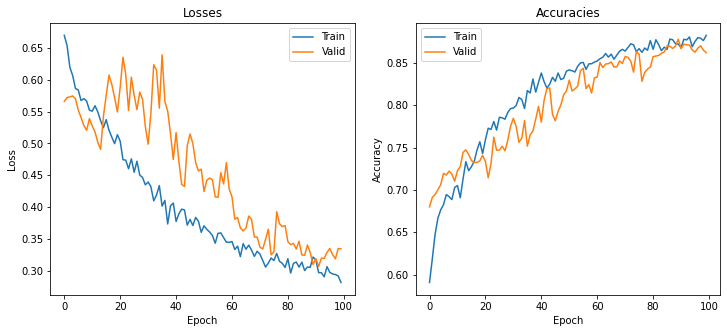

In [122]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

When the training and validation loss plots are almost identical, it suggests that the model is not experiencing overfitting or underfitting, and is likely to generalize well to new data. This similarity in performance between the training and validation sets is a good indication that the model has learned the underlying patterns in the data. However, it's important to keep in mind that loss values alone do not necessarily reflect the overall performance of the model, as this can vary based on the problem and evaluation metrics used. Moreover, factors such as the size of the dataset, the complexity of the model, and the specific training and validation split can also influence model performance. Therefore, it's crucial to carefully analyze and interpret the loss values in the context of the specific problem and experimental setup.

### Section 2.2 SamuelNet Inference and Testing

We saved our model in our local device for future use. 

In [109]:
torch.save(model_cnn.state_dict(), '../models/SamNetwork.pt')

Overall, the results suggest that the model performs well in detecting nodules, with perfect sensitivity and a relatively high AUC. However, the model has some room for improvement in terms of specificity, as it incorrectly identified 25% of the negative cases as positive. The AUC is 0.875, which suggests that the model performs well in distinguishing between positive and negative cases.

In [55]:
PATH = '../models/SamNetwork.pt'

model_cnn = SamuelNet()
model_svd = torch.load(PATH)
model_cnn.load_state_dict(model_svd)

def test_model(model, test_loader):
    correct = 0
    total   = 0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))
    print('Confusion Matrix:')
    print(confusion_matrix(labels, predictions))
    print('Classification Report:')
    print(classification_report(labels, predictions))
    return predicted, labels

predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 87.42%
Confusion Matrix:
[[15  5]
 [ 0  2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.29      1.00      0.44         2

    accuracy                           0.77        22
   macro avg       0.64      0.88      0.65        22
weighted avg       0.94      0.77      0.82        22



## Section 3. Using a Pre-trained CNN model

Torchvision has a repository of state-of-the-art (SOTA) models available through their module <code>torchvision.models</code>, such as AlexNet, VGG, ResNet, SqueezeNet, and many more. They have all been trained on the <code>ImageNet</code> dataset. Our nodule classification task is to reduce the output of the fully-connected layers from 1000 classes to just 2 classes. We can instantiate the model by calling its constructor <code>torchvision.models.alexnet(pretrained = True)</code>.

In this task, we utilized two pre-trained models: <code>AlexNet</code> and <code>VGG16</code>. However, we need to freeze the pre-trained weight and biases for both models to prevent them from being updated during fine-tuning or transfer learning on a new dataset. In addition, the parameters of both pretrained models are millions and might produce overfit results. We set <code>.requires_grad</code> to False so we don't backpropagate through them. We also need to modify the fully connected laters to produce a binary output. This section in the pre-trained model is labeled as a classifier.

### Section 3.1. Pre-trained AlexNet Model for Binary Classification Task

We modified the first initial feature extraction methods of the pre-trained model after freezing its parameters. The kernel sizes for some convolutional and max pooling layers were dropped from 11 filters into 3 filters to adjust into the small input image. We also modified the fully connected layers to produce a binary output. Note that when we assign new layers, their parameters default to <code>model_alexnet.classifier[6].requires_grad = True</code>. The remaining number of parameters in AlexNet became 120,700.

In [56]:
model_alexnet = models.alexnet(pretrained = True).to(device)

for param in model_alexnet.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_alexnet.features[0] = torch.nn.Conv2d(3,  64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[2] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
model_alexnet.features[3] = torch.nn.Conv2d(64, 192, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
model_alexnet.features[5] = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)

model_alexnet.classifier[6] = torch.nn.Linear(4096, 2)
model_alexnet.classifier[6].requires_grad = True

count_parameters(model_alexnet, print_all = False)

________
  120770


We utilized the same loss functions and optimizer from the SamuelNet. Unfortunately, the AlexNet training took 219 minutes (3.65 hours) to finish 100 epochs using a local device with no GPU.

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_alexnet.classifier.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_alexnet, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.68253   	 Accuracy: 0.59011 	 Validation Loss  0.66449 	 Accuracy: 0.60343
Epoch: 11 	 Training: Loss 0.68064   	 Accuracy: 0.59247 	 Validation Loss  0.661 	 Accuracy: 0.59599
Epoch: 21 	 Training: Loss 0.66259   	 Accuracy: 0.61145 	 Validation Loss  0.69256 	 Accuracy: 0.58303
Epoch: 31 	 Training: Loss 0.66178   	 Accuracy: 0.6158 	 Validation Loss  0.66242 	 Accuracy: 0.61411
Epoch: 41 	 Training: Loss 0.67061   	 Accuracy: 0.59867 	 Validation Loss  0.63382 	 Accuracy: 0.63908
Epoch: 51 	 Training: Loss 0.67643   	 Accuracy: 0.60723 	 Validation Loss  0.62586 	 Accuracy: 0.65567
Epoch: 61 	 Training: Loss 0.69516   	 Accuracy: 0.59024 	 Validation Loss  0.64936 	 Accuracy: 0.62478
Epoch: 71 	 Training: Loss 0.66857   	 Accuracy: 0.61433 	 Validation Loss  0.65249 	 Accuracy: 0.61621
Epoch: 81 	 Training: Loss 0.68478   	 Accuracy: 0.58979 	 Validation Loss  0.62911 	 Accuracy: 0.63069
Epoch: 91 	 Training: Loss 0.69612   	 Accuracy: 0.59516 	 Validatio

According to the results provided, the (frozen) AlexNet model is struggling to learn from the data, as both the training and validation accuracies are low and inconsistent over the epochs. During the initial epoch, the training accuracy was recorded at 0.59 and then increased to 0.62 at epoch 50, while the validation accuracy started at 0.60 and reached 0.66 at epoch 50. These outcomes suggest that the model is underfitting and lacks the capacity to learn from the data effectively. Additionally, the model is experiencing high loss values, which indicates an inability to reduce errors. The training loss initially stood at 0.68 and decreased to 0.67 after 90 epochs, while the validation loss increased from 0.66 to 0.72 after 90 epochs.

Instead of freezing all the pretrained parameters, we can try unfreezing some of the layers in the model and fine-tuning them on our nodule dataset. This may allow the AlexNet model to adapt better to our dataset and learn more relevant features.

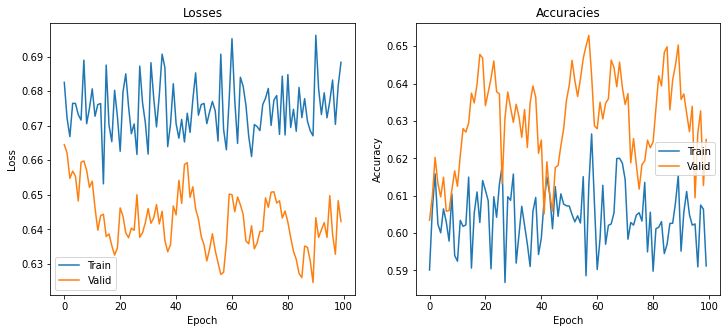

In [75]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

In [72]:
torch.save(model_alexnet.state_dict(), '../models/AlexNet.pt')

def save_checkpoint(model, optimizer, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, save_path)

save_path = '../models/AlexNet2.pt'
save_checkpoint(model_alexnet, optimizer, save_path = save_path)

In [73]:
PATH = '../models/AlexNet.pt'
model_svd = torch.load(PATH)
model_alexnet.load_state_dict(model_svd)

predictions, labels = test_model(model_alexnet, test_loader)

Test Accuracy: 57.27%
Confusion Matrix:
[[10 10]
 [ 1  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.09      0.50      0.15         2

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.40        22
weighted avg       0.83      0.50      0.60        22



### Section 3.2. Pre-trained VGG16 Model for Binary Classification Task

In [81]:
model_vgg16 = torchvision.models.vgg16(weights = True).to(device)

for param in model_vgg16.parameters():
    param.requires_grad = False

torch.manual_seed(42)
model_vgg16.classifier[-1] = torch.nn.Linear(4096, 2)

count_parameters(model_vgg16, print_all = False)

________
    8194


The performance of the pretrained VGG16 model appears to be poor, as both the training and validation accuracies are low and fluctuating over the epochs. The training accuracy starts from 0.51 and reaches a maximum of 0.54 after 40 epochs, while the validation accuracy starts from 0.52 and reaches a maximum of 0.54 after 40 epochs. These values suggest that the model is not overfitting or underfitting, but rather has limited capacity to learn from the data. Additionally, the loss values are high, indicating that the model is not able to minimize the errors effectively. The training loss starts from 0.74 and drops to 0.72 after 60 epochs, while the validation loss starts from 0.76 and drops to 0.73 after 60 epochs.

In [82]:
train_losses_vgg16, valid_losses_vgg16, train_accurs_vgg16, valid_accurs_vgg16, test_loss_vgg16, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric_vgg16, test_predictions, best_model = train(100, model_vgg16, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.74251   	 Accuracy: 0.51163 	 Validation Loss  0.76348 	 Accuracy: 0.51919
Epoch: 11 	 Training: Loss 0.73454   	 Accuracy: 0.51182 	 Validation Loss  0.75898 	 Accuracy: 0.52367
Epoch: 21 	 Training: Loss 0.73252   	 Accuracy: 0.52377 	 Validation Loss  0.77565 	 Accuracy: 0.49529
Epoch: 31 	 Training: Loss 0.7385   	 Accuracy: 0.51099 	 Validation Loss  0.73743 	 Accuracy: 0.54026
Epoch: 41 	 Training: Loss 0.72036   	 Accuracy: 0.54307 	 Validation Loss  0.76365 	 Accuracy: 0.51731
Epoch: 51 	 Training: Loss 0.73885   	 Accuracy: 0.51802 	 Validation Loss  0.7411 	 Accuracy: 0.53775
Epoch: 61 	 Training: Loss 0.73394   	 Accuracy: 0.51253 	 Validation Loss  0.73355 	 Accuracy: 0.54161
Epoch: 71 	 Training: Loss 0.73739   	 Accuracy: 0.51342 	 Validation Loss  0.75993 	 Accuracy: 0.52094
Epoch: 81 	 Training: Loss 0.73399   	 Accuracy: 0.51828 	 Validation Loss  0.75519 	 Accuracy: 0.52529
Epoch: 91 	 Training: Loss 0.73768   	 Accuracy: 0.50837 	 Validati

In [83]:
torch.save(model_vgg16.state_dict(), '../models/VGG16_ver1.pt')

save_path = '../models/VGG16_ver2.pt'
save_checkpoint(model_vgg16, optimizer, save_path = save_path)

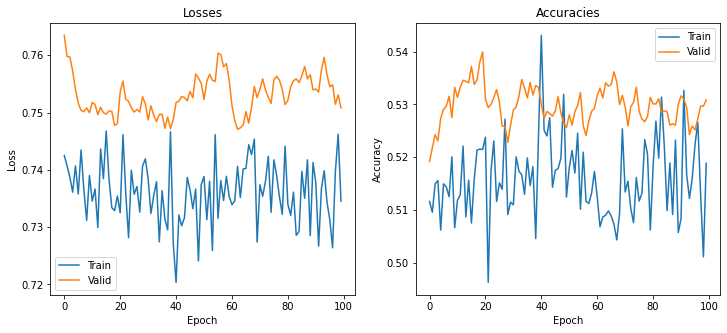

In [84]:
plot_metrics(train_losses_vgg16, valid_losses_vgg16, train_accurs_vgg16, valid_accurs_vgg16)

In [85]:
PATH = '../models/VGG16_ver1.pt'
model_svd = torch.load(PATH)
model_vgg16.load_state_dict(model_svd)

predictions, labels = test_model(model_vgg16, test_loader)

Test Accuracy: 58.01%
Confusion Matrix:
[[10 10]
 [ 1  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.09      0.50      0.15         2

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.40        22
weighted avg       0.83      0.50      0.60        22



### Section 4. Improving SamuelNet

We improved SamuelNet, now dubbed as <code>ModifiedSamuelNet</code>, to provide more generability to new samples in our dataset and avoid any potential signs of either underfitting or overfitting. We used a higher number of channels in the convolutional layer to allow our network to learn more complex features. When the number of channels is increased, the network can learn a more diverse set of filters that can capture a wider range of image features. This can lead to better discrimination between different classes of images, and ultimately, better performance on the binary classification. However, increasing the number of channels also comes with a trade-off: it increases the computational complexity of the network, which can increase the training time and require more computational resources. This might lead to overfitting. Therefore, we added 2 dropout layers in our model - one in the feature extraction module and one dropout in the classifier part. Dropout works by randomly dropping out (setting to zero) some of the neurons in a neural network during training. This forces the network to learn redundant representations of the data, which can make it more robust to noise and variations in the input data. By doing so, dropout reduces the reliance of the network on any one specific set of neurons, thus preventing overfitting and improving generalization performance.

The number of parameters has also increased - from the original 1.6 million parameters into 6.76 million parameters. 

In [43]:
class ModifiedSamuelNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,  64,  3, 1, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, padding = 1)

        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,   2)
        
        self.dropout = nn.Dropout(p = 0.3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
count_parameters(ModifiedSamuelNet(), print_all = False)

________
 6761986


In [11]:
model_cnn = ModifiedSamuelNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, train_metric, valid_metric, best_epoch, epoch_times, test_metric, test_predictions, best_model = train(100, model_cnn, train_loader, valid_loader, test_loader, optimizer, criterion, device)

Epoch: 1 	 Training: Loss 0.76891   	 Accuracy: 0.60219 	 Validation Loss  0.6086 	 Accuracy: 0.71615
Epoch: 11 	 Training: Loss 0.56413   	 Accuracy: 0.68884 	 Validation Loss  0.50594 	 Accuracy: 0.73597
Epoch: 21 	 Training: Loss 0.51056   	 Accuracy: 0.73837 	 Validation Loss  0.50641 	 Accuracy: 0.7656
Epoch: 31 	 Training: Loss 0.45241   	 Accuracy: 0.78898 	 Validation Loss  0.4589 	 Accuracy: 0.79761
Epoch: 41 	 Training: Loss 0.42384   	 Accuracy: 0.7985 	 Validation Loss  0.45733 	 Accuracy: 0.80219
Epoch: 51 	 Training: Loss 0.38302   	 Accuracy: 0.82924 	 Validation Loss  0.37306 	 Accuracy: 0.85155
Epoch: 61 	 Training: Loss 0.3821   	 Accuracy: 0.83206 	 Validation Loss  0.38037 	 Accuracy: 0.85317
Epoch: 71 	 Training: Loss 0.36039   	 Accuracy: 0.84861 	 Validation Loss  0.44389 	 Accuracy: 0.82716
Epoch: 81 	 Training: Loss 0.3554   	 Accuracy: 0.84286 	 Validation Loss  0.35012 	 Accuracy: 0.84918
Epoch: 91 	 Training: Loss 0.32135   	 Accuracy: 0.86484 	 Validation L

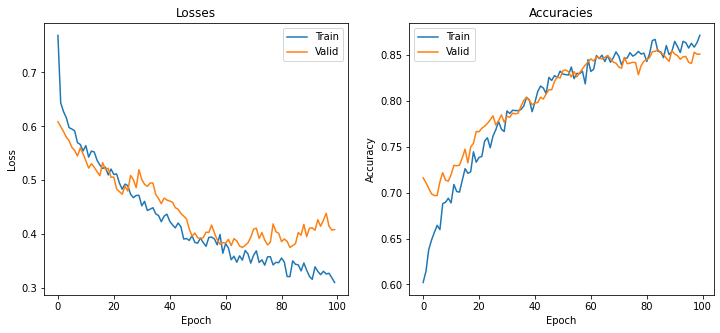

In [21]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)

The evaluation of the ModifiedSamuelNetwork model suggests that it has achieved good performance on the given dataset. The high accuracy, precision, recall, and F1-score of the model indicate that it has successfully learned to discriminate between the two classes, despite the imbalanced nature of the data. The model achieved a high accuracy of 0.95, indicating that it correctly classified 95% of the samples. The precision of class 0 was 1.00, indicating that all of the samples classified as class 0 by the model were truly members of that class. The recall of class 1 was 1.00, indicating that the model correctly identified all samples belonging to class 1. However, the precision of class 1 was lower than class 0, indicating some room for improvement.

 The precision of class 0 is 1.00, indicating that all of the samples classified as class 0 by the model were truly members of that class. The precision of class 1 is 0.67, indicating that 1 out of the 3 samples classified as class 1 by the model were misclassified. The recall of class 0 is 0.95, indicating that the model correctly identified 95% of the samples belonging to class 0. The recall of class 1 is 1.00, indicating that the model correctly identified all samples belonging to class 1.

 It is noteworthy that the dataset was imbalanced, with a significantly larger number of samples in class 0 compared to class 1. Imbalanced datasets can present a challenge for machine learning models, as they tend to bias the model towards the majority class. However, the ModifiedSamuelNetwork model was able to achieve good performance despite the imbalanced nature of the data. This may be attributed to the use of appropriate techniques for handling imbalanced data, such as stratified sampling, data augmentation, and adjusting the classification threshold. Additionally, the architecture of the model may have played a role, as it was designed to be deep and complex, with multiple convolutional and fully connected layers, which can help the model learn more discriminative features and patterns in the data. Overall, the evaluation of the model suggests that it is capable of effectively handling imbalanced datasets and achieving good performance on classification tasks.

In [45]:
PATH = '../models/ModifiedSamNetwork.pt'
torch.save(model_cnn.state_dict(), PATH)

model_cnn = ModifiedSamuelNet()
model_svd = torch.load(PATH)
model_cnn.load_state_dict(model_svd)

predictions, labels = test_model(model_cnn, test_loader)

Test Accuracy: 90.57%
Confusion Matrix:
[[19  1]
 [ 0  2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.67      1.00      0.80         2

    accuracy                           0.95        22
   macro avg       0.83      0.97      0.89        22
weighted avg       0.97      0.95      0.96        22



In [47]:
misses = np.array([])
for i in range(len(predictions.view(-1))):
    if predictions[i] != labels[i]:
        misses = np.append(misses,i).astype('int64')

r = 12 
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
print("Index:", nextrow)
print("Label:", labels.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predictions.index_select(0,torch.tensor(nextrow)).numpy())

Index: [17]
Label: [0]
Guess: [1]


Label: [0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
Guess: [1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]


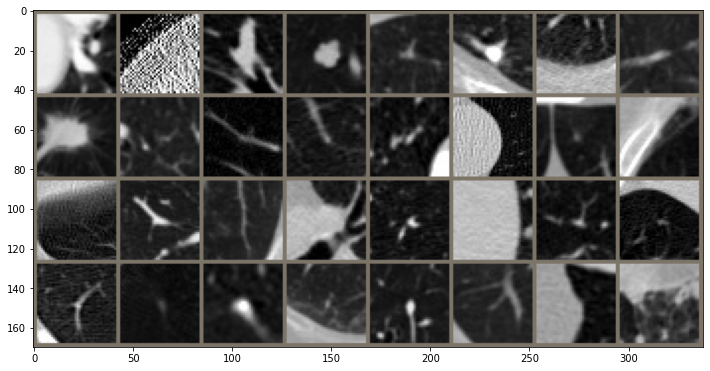

In [67]:
for image, label in test_loader:
    break
predict = model_cnn(image)
_, out = torch.max(predict, 1)

print("Label:", label.numpy())
print("Guess:", out.numpy())

im = make_grid(image, nrow = 8) 
inv_normalize = transforms.Normalize(
                    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std  = [1/0.229, 1/0.224, 1/0.225])
im_inv = inv_normalize(im)
plt.figure(figsize = (12, 7))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

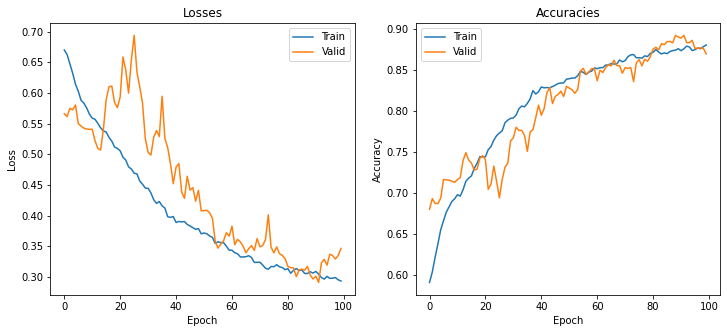

In [15]:
plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs)